## import pandas as pd
import numpy as np
import csv
from datetime import datetime
import matplotlib.dates
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.stats import mstats
import datetime

import sys
import math
import gurobipy as gp
from gurobipy import GRB
from itertools import permutations

In [2]:
df = pd.read_excel("Density vs Growth.xlsx")
df = df.drop(columns = "Index")
df

Density   Growth_Rate
0       0.11  3.533045e-04
1       0.12  3.532331e-04
2       0.13  3.531378e-04
3       0.14  3.530416e-04
4       0.15  3.529463e-04
..       ...           ...
907     9.18 -1.035845e-07
908     9.19 -3.654173e-07
909     9.20  1.600610e-07
910     9.21 -5.818369e-08
911     9.22 -5.303511e-08

[912 rows x 2 columns]

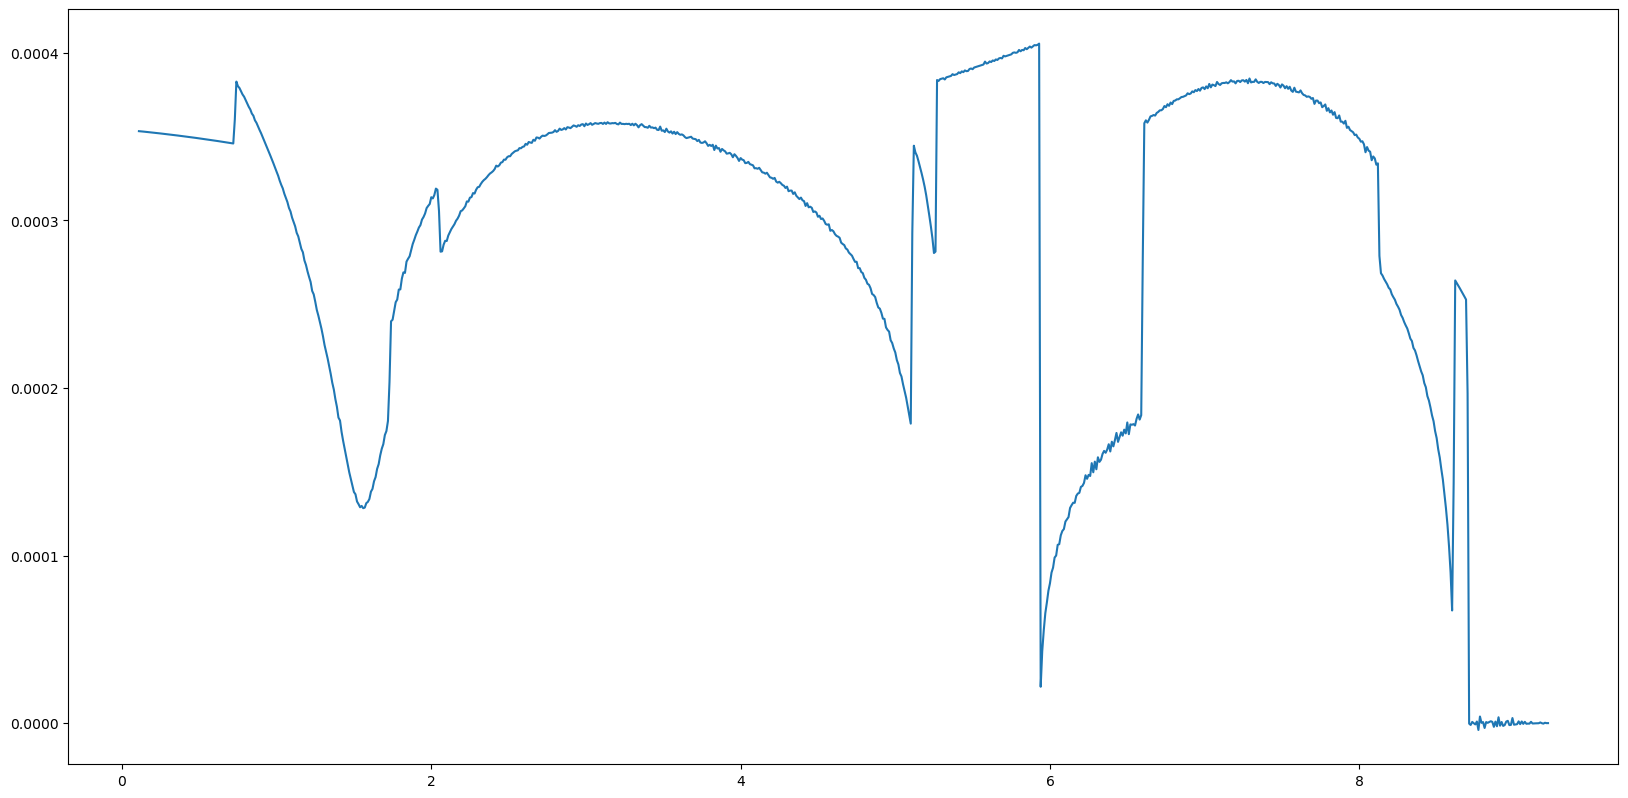

In [3]:
figure(figsize=(20, 10), dpi=100)
plt.plot(df["Density"], df["Growth_Rate"])
plt.show()

C:\Users\timwy\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


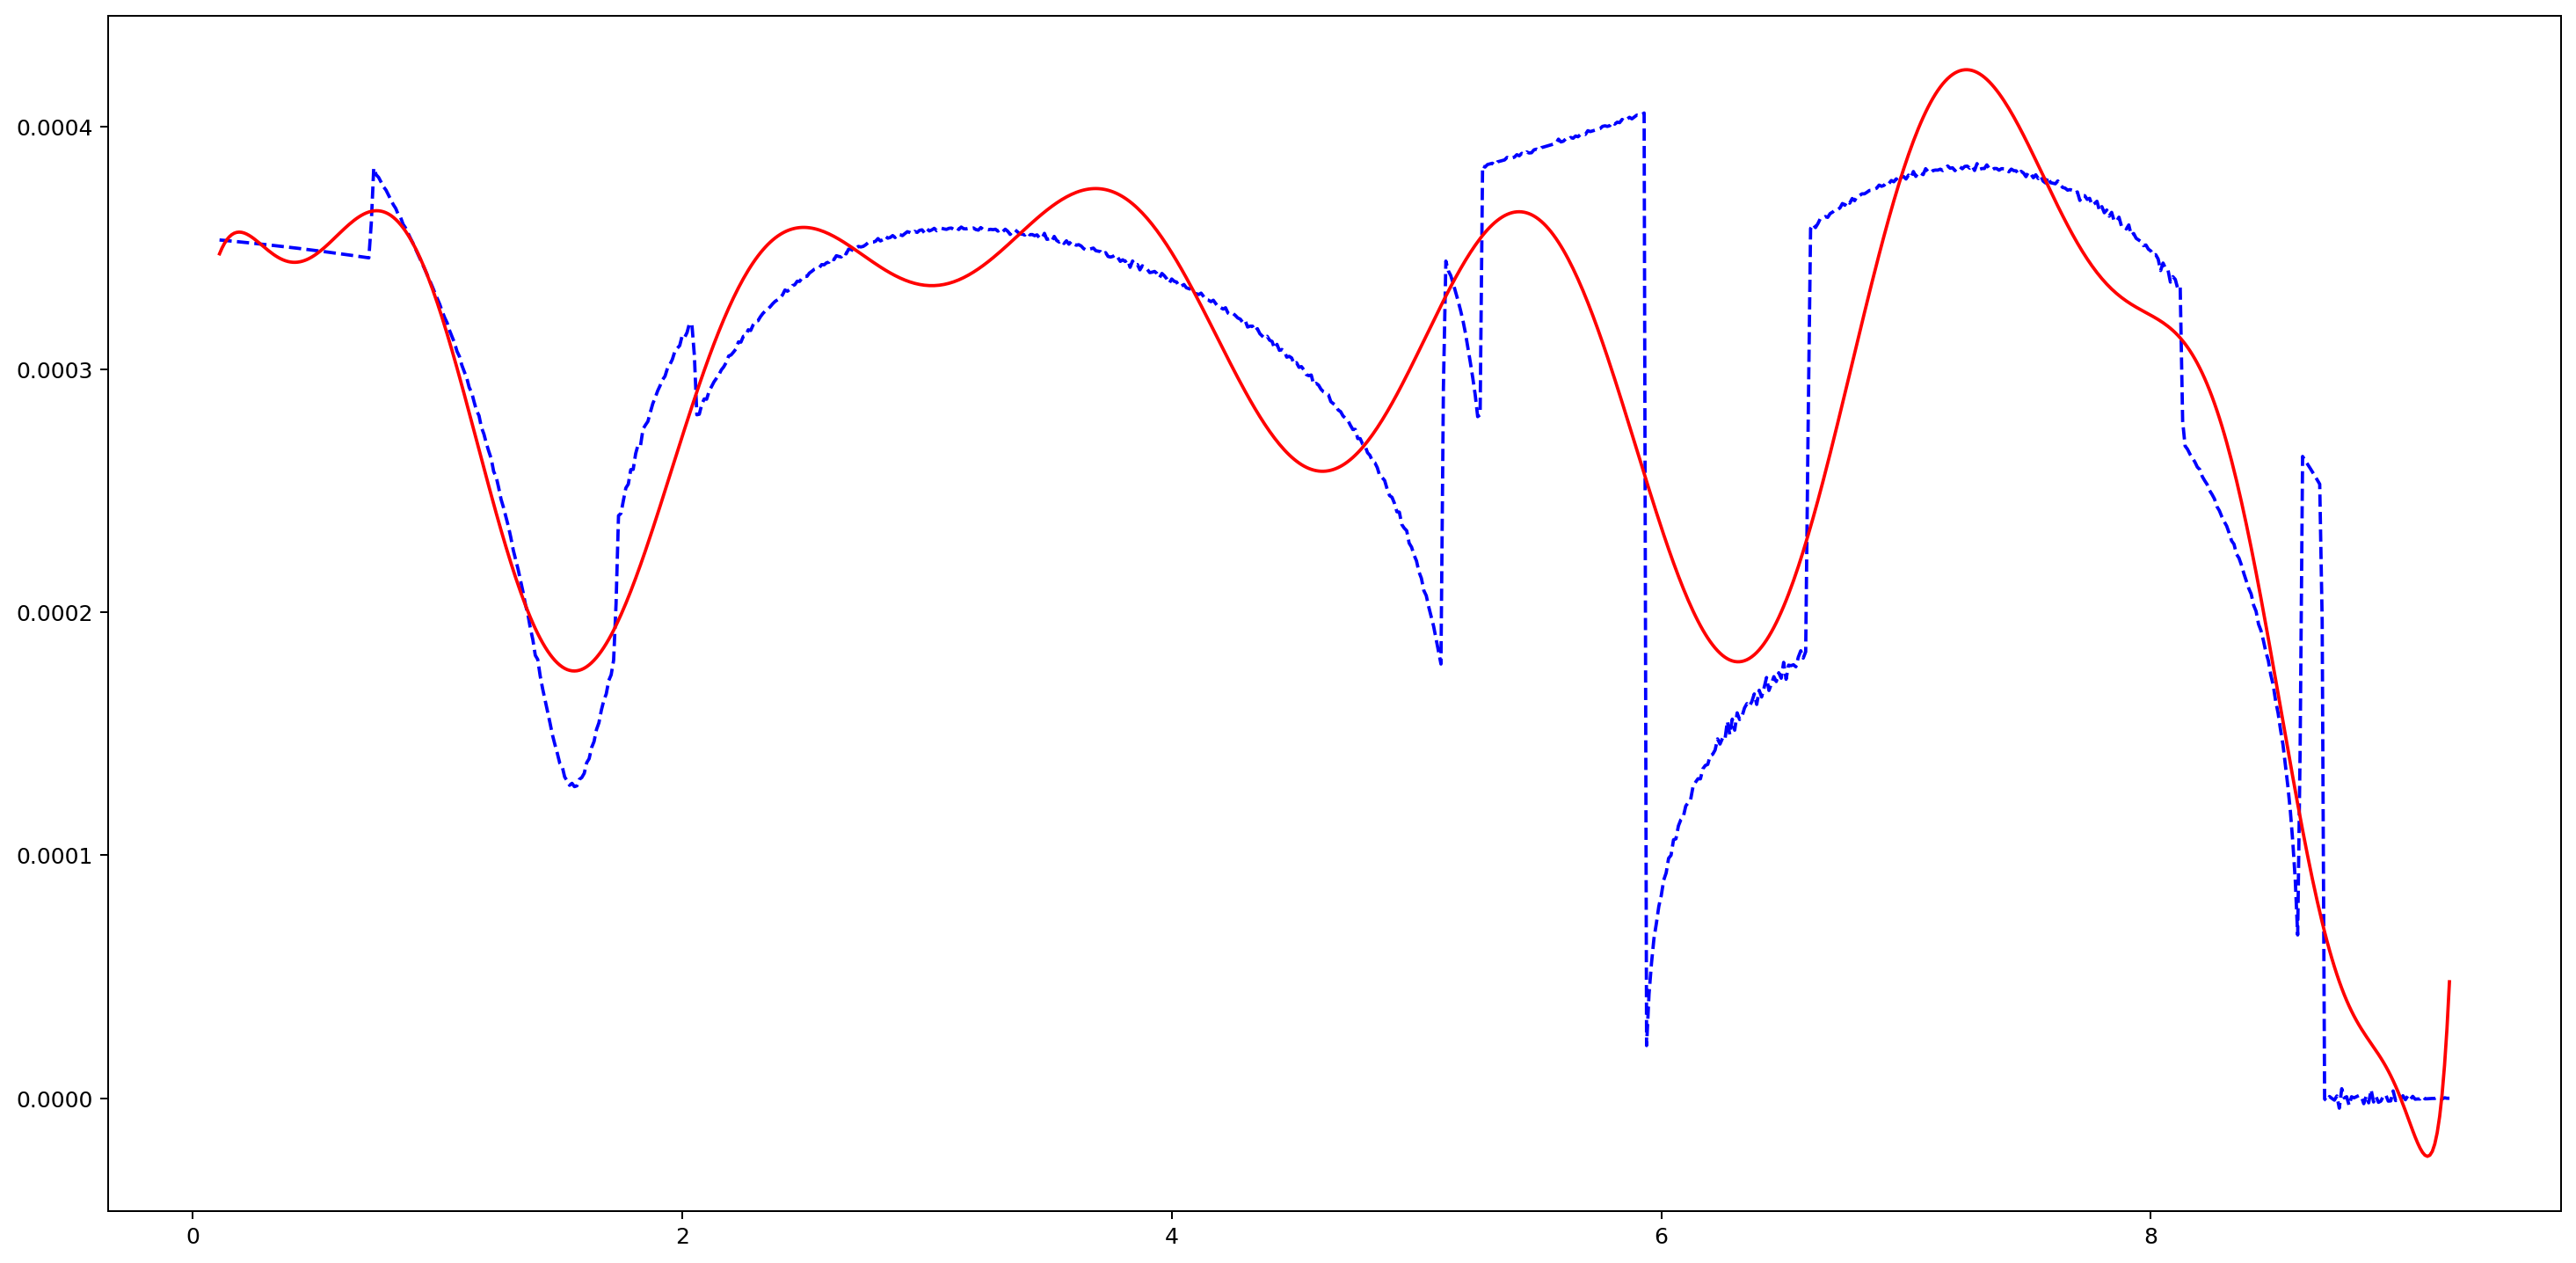

In [4]:
degree = 20
x = df["Density"]
y = df["Growth_Rate"]
theta = np.polyfit(x,y, deg= degree)
model_plot = np.poly1d(theta)

figure(figsize=(20, 10), dpi=180)
plt.plot(x, y, 'b--')
plt.plot(x, model_plot(x),'r')

In [5]:
# simplify the growth rate vs density plot with step function
growth = []
for i in range(len(x)):
    if model_plot(x[i])>=0 and model_plot(x[i])<0.0001:
        growth.append((0.0001+0)/2)
    elif model_plot(x[i])>=0.0001 and model_plot(x[i])<0.0002:
        growth.append((0.0001+0.0002)/2)
    elif model_plot(x[i])>=0.0002 and model_plot(x[i])<0.0003:
        growth.append((0.0002+0.0003)/2)
    elif model_plot(x[i])>=0.0003 and model_plot(x[i])<0.0004:
        growth.append((0.0003+0.0004)/2)
    elif model_plot(x[i])>=0.0004 and model_plot(x[i])<0.0005:
        growth.append((0.0004+0.0005)/2)
    else:
        growth.append(0)
df["Growth_approx"] = growth

In [6]:
df["Growth_approx"][400]

0.00035

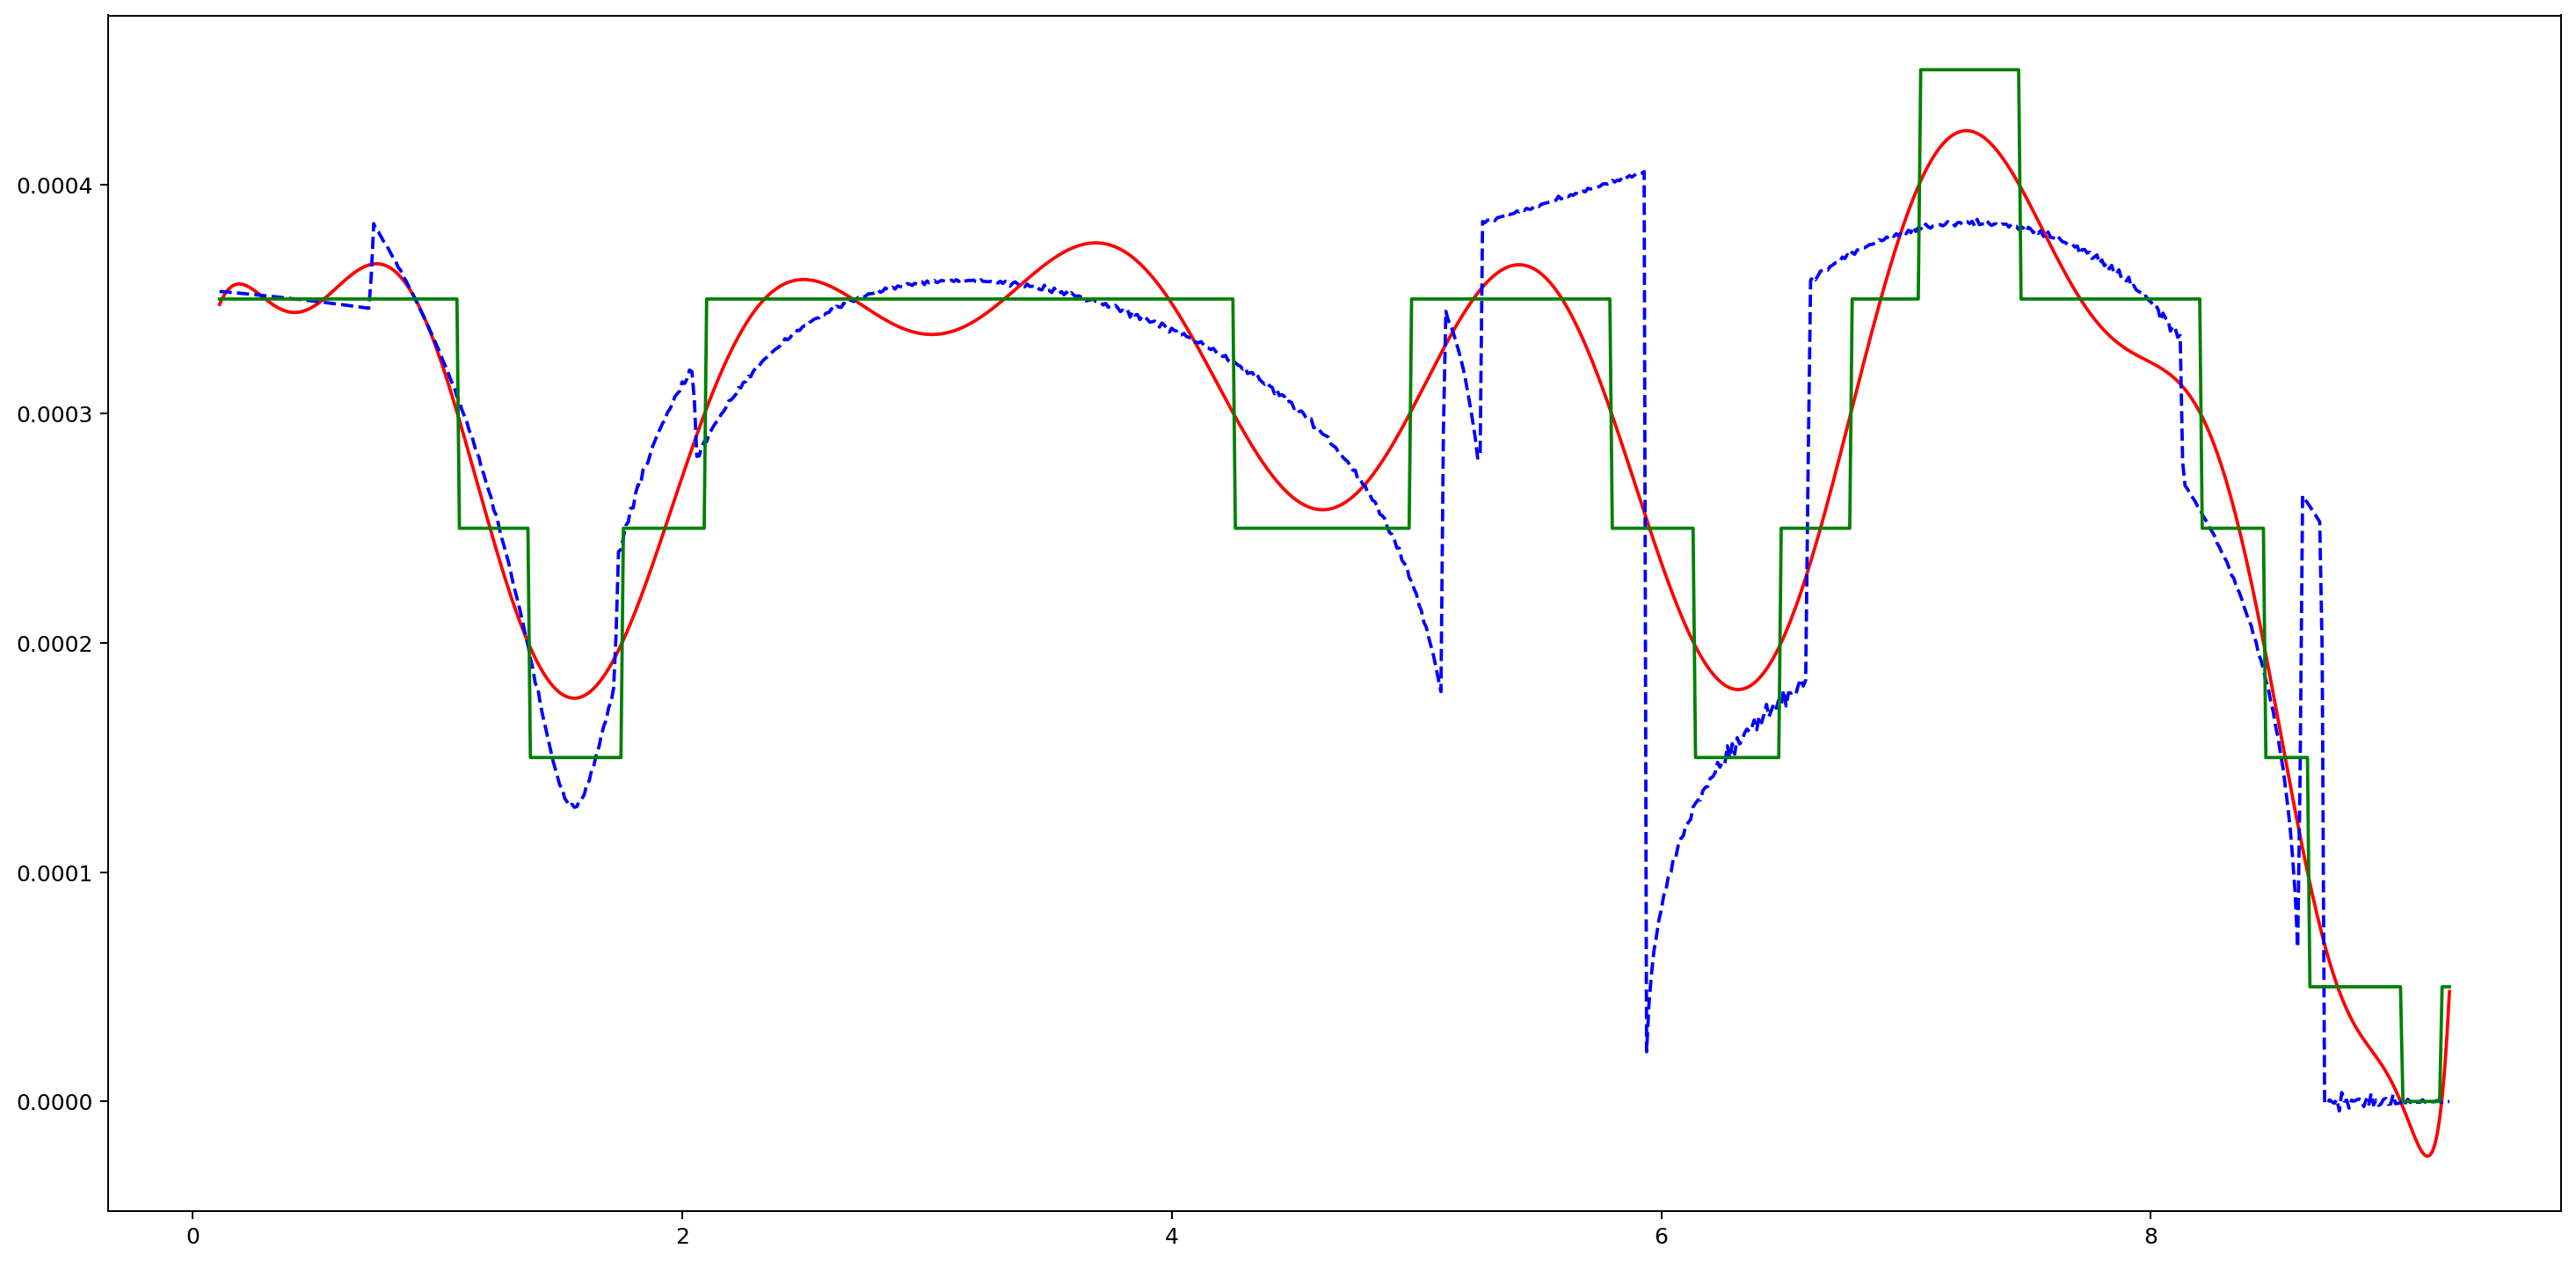

In [7]:
degree = 20
x = df["Density"]
y = df["Growth_Rate"]
z = df["Growth_approx"]

figure(figsize=(20, 10), dpi=180)
plt.plot(x, model_plot(x),'r')
plt.plot(x, y, 'b--')
plt.plot(x, z, 'g')

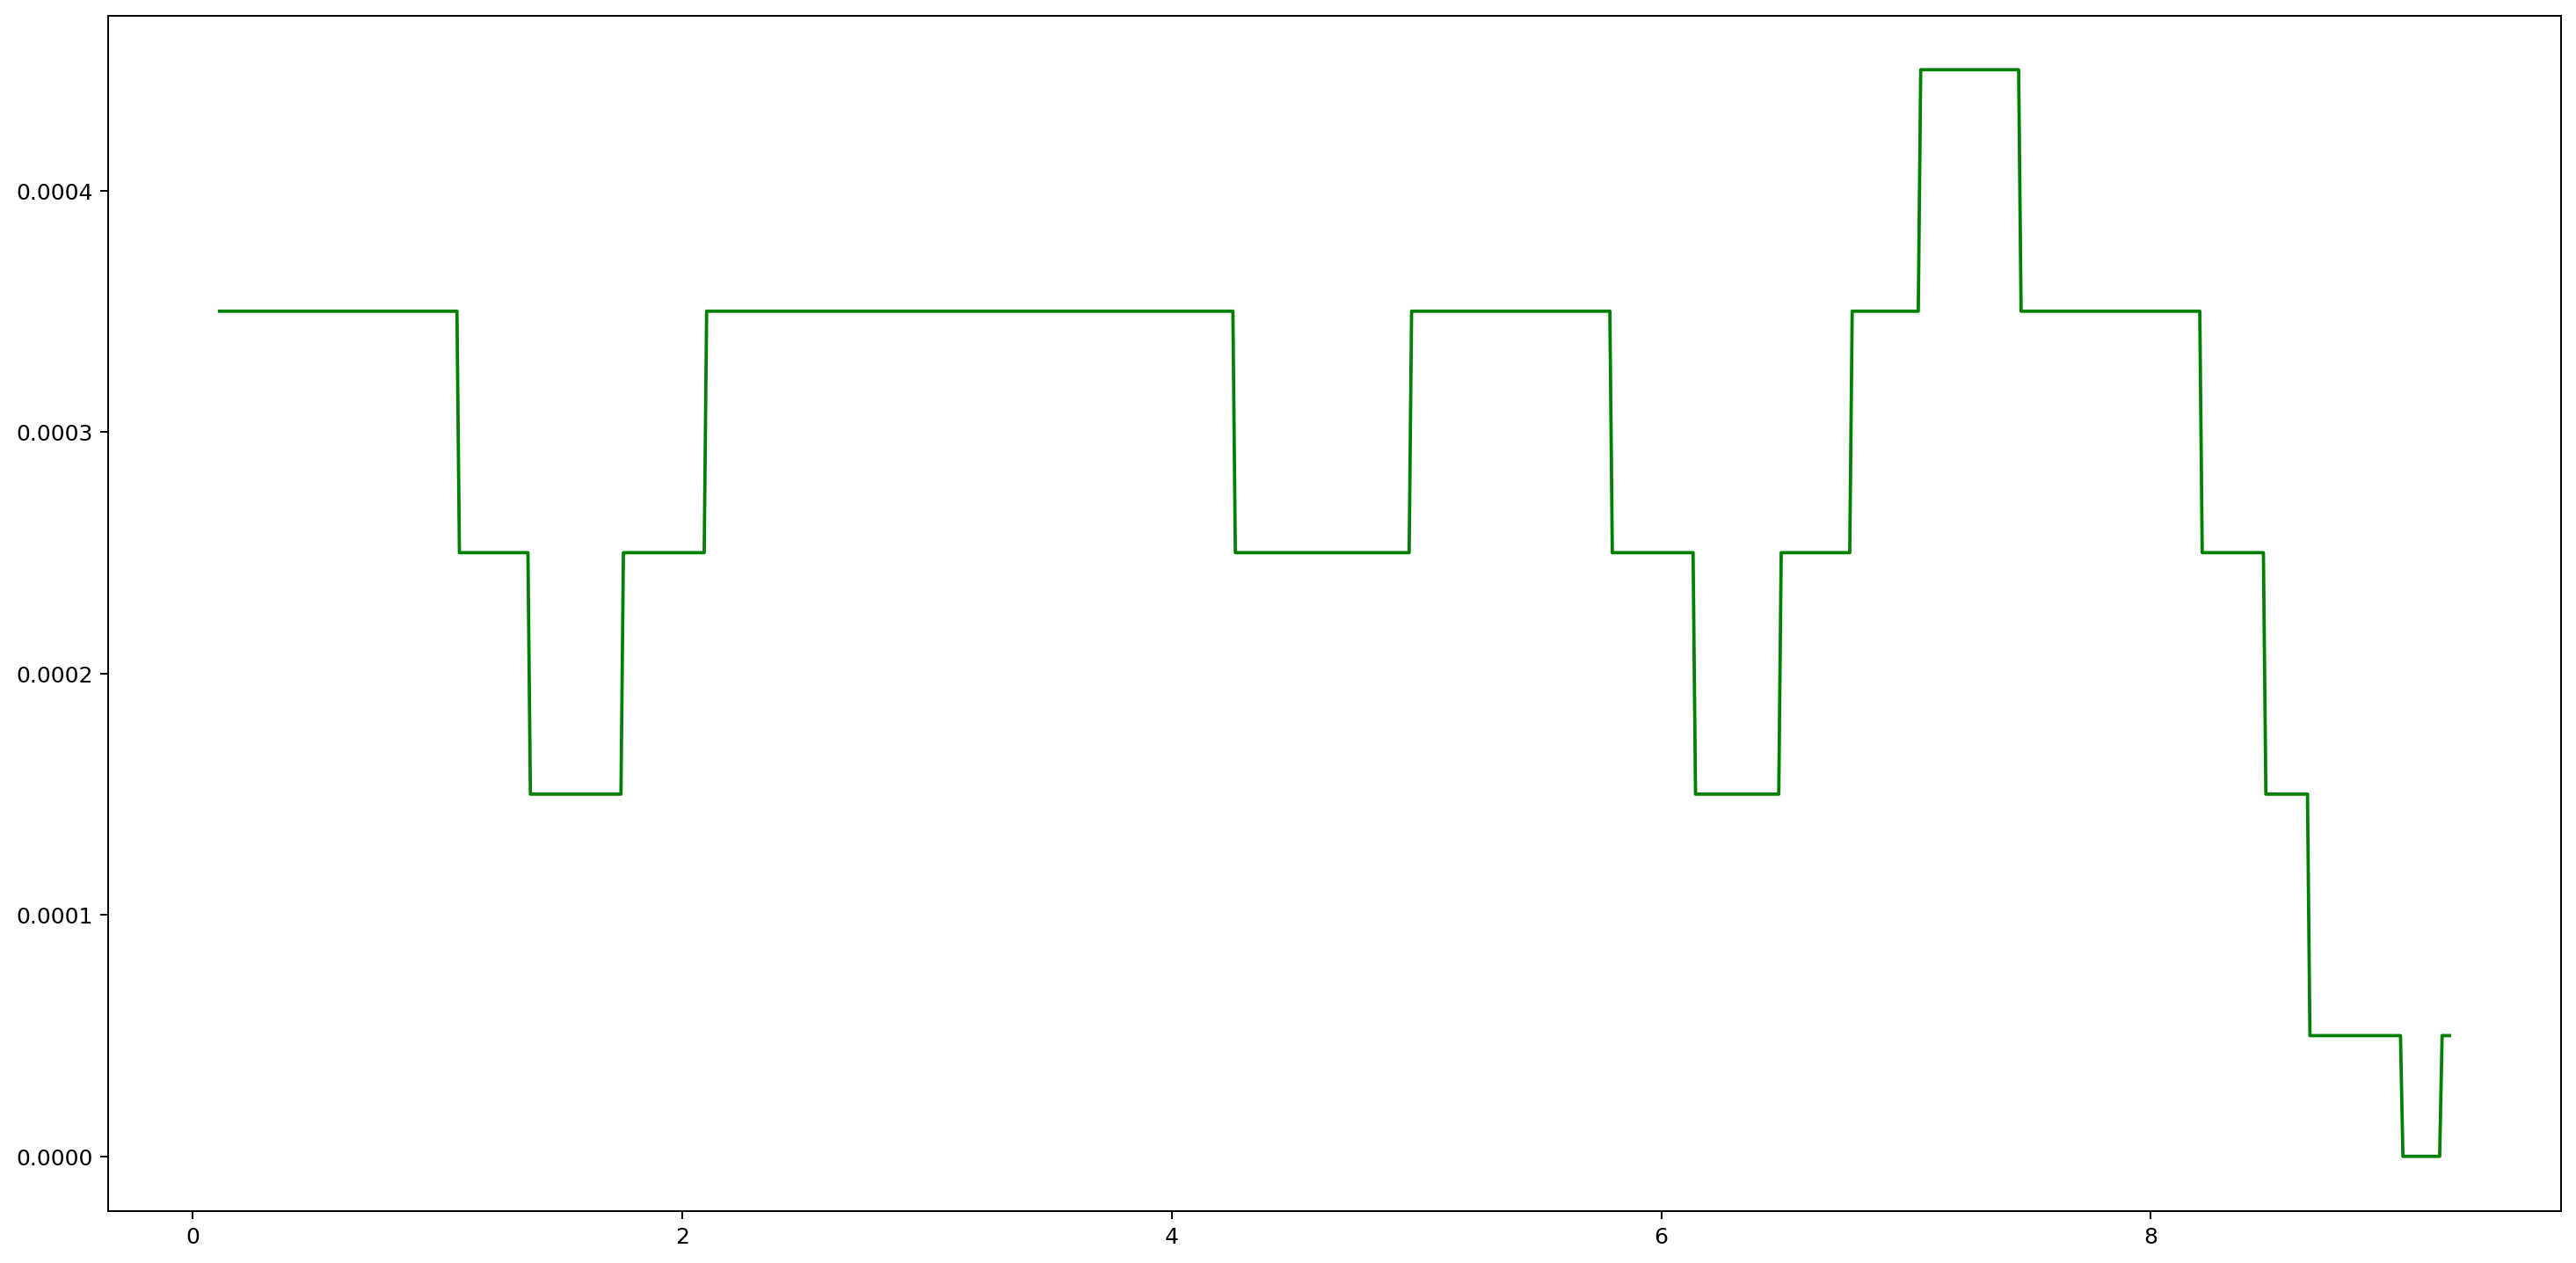

In [8]:
figure(figsize=(20, 10), dpi=180)
plt.plot(x, z, 'g')

# Following Part
the processing part here is manual and could be done according to one's preference.

In [9]:
turn = []
# find all the turning point for the step function
for i in range(1,len(x)):
    if z[i]!=z[i-1]:
        turn.append(x[i])
turn

[1.09,
 1.38,
 1.76,
 2.1,
 4.26,
 4.98,
 5.8,
 6.14,
 6.49,
 6.78,
 7.06,
 7.47,
 8.21,
 8.47,
 8.65,
 9.03,
 9.19]

In [10]:
#simplify the growth rate plot for easier computation (basically merging smaller steps into one big step)
growth_adjust = []
for i in range(len(x)):
    if i>=0 and i<int((1.09+1.38-0.04)/2*100):
        growth_adjust.append(0.00035)
    elif i>=int((1.09+1.38-0.04)/2*100) and i<int((1.76+2.1-0.04)/2*100):
        growth_adjust.append(0.00015)
    elif i>=int((1.76+2.1-0.04)/2*100) and i<int((4.26-0.02)*100):
        growth_adjust.append(0.00035)
    elif i>=int((4.26-0.02)*100) and i<int((4.98-0.02)*100):
        growth_adjust.append(0.00025)
    elif i>=int((4.98-0.02)*100) and i<int((5.8+6.14-0.04)/2*100):
        growth_adjust.append(0.00035) 
    elif i>=int((5.8+6.14-0.04)/2*100) and i<int((6.49+7.06-0.04)/2*100):
        growth_adjust.append(0.00015)
    elif i>=int((6.49+7.06-0.04)/2*100) and i<int((7.47-0.02)*100):
        growth_adjust.append(0.00045)
    elif i>=int((7.47-0.02)*100) and i<int((8.47-0.02)*100):
        growth_adjust.append(0.00035)
    elif i>=int((8.47-0.02)*100) and i<len(x):
        growth_adjust.append(0.00005)
len(growth_adjust)

912

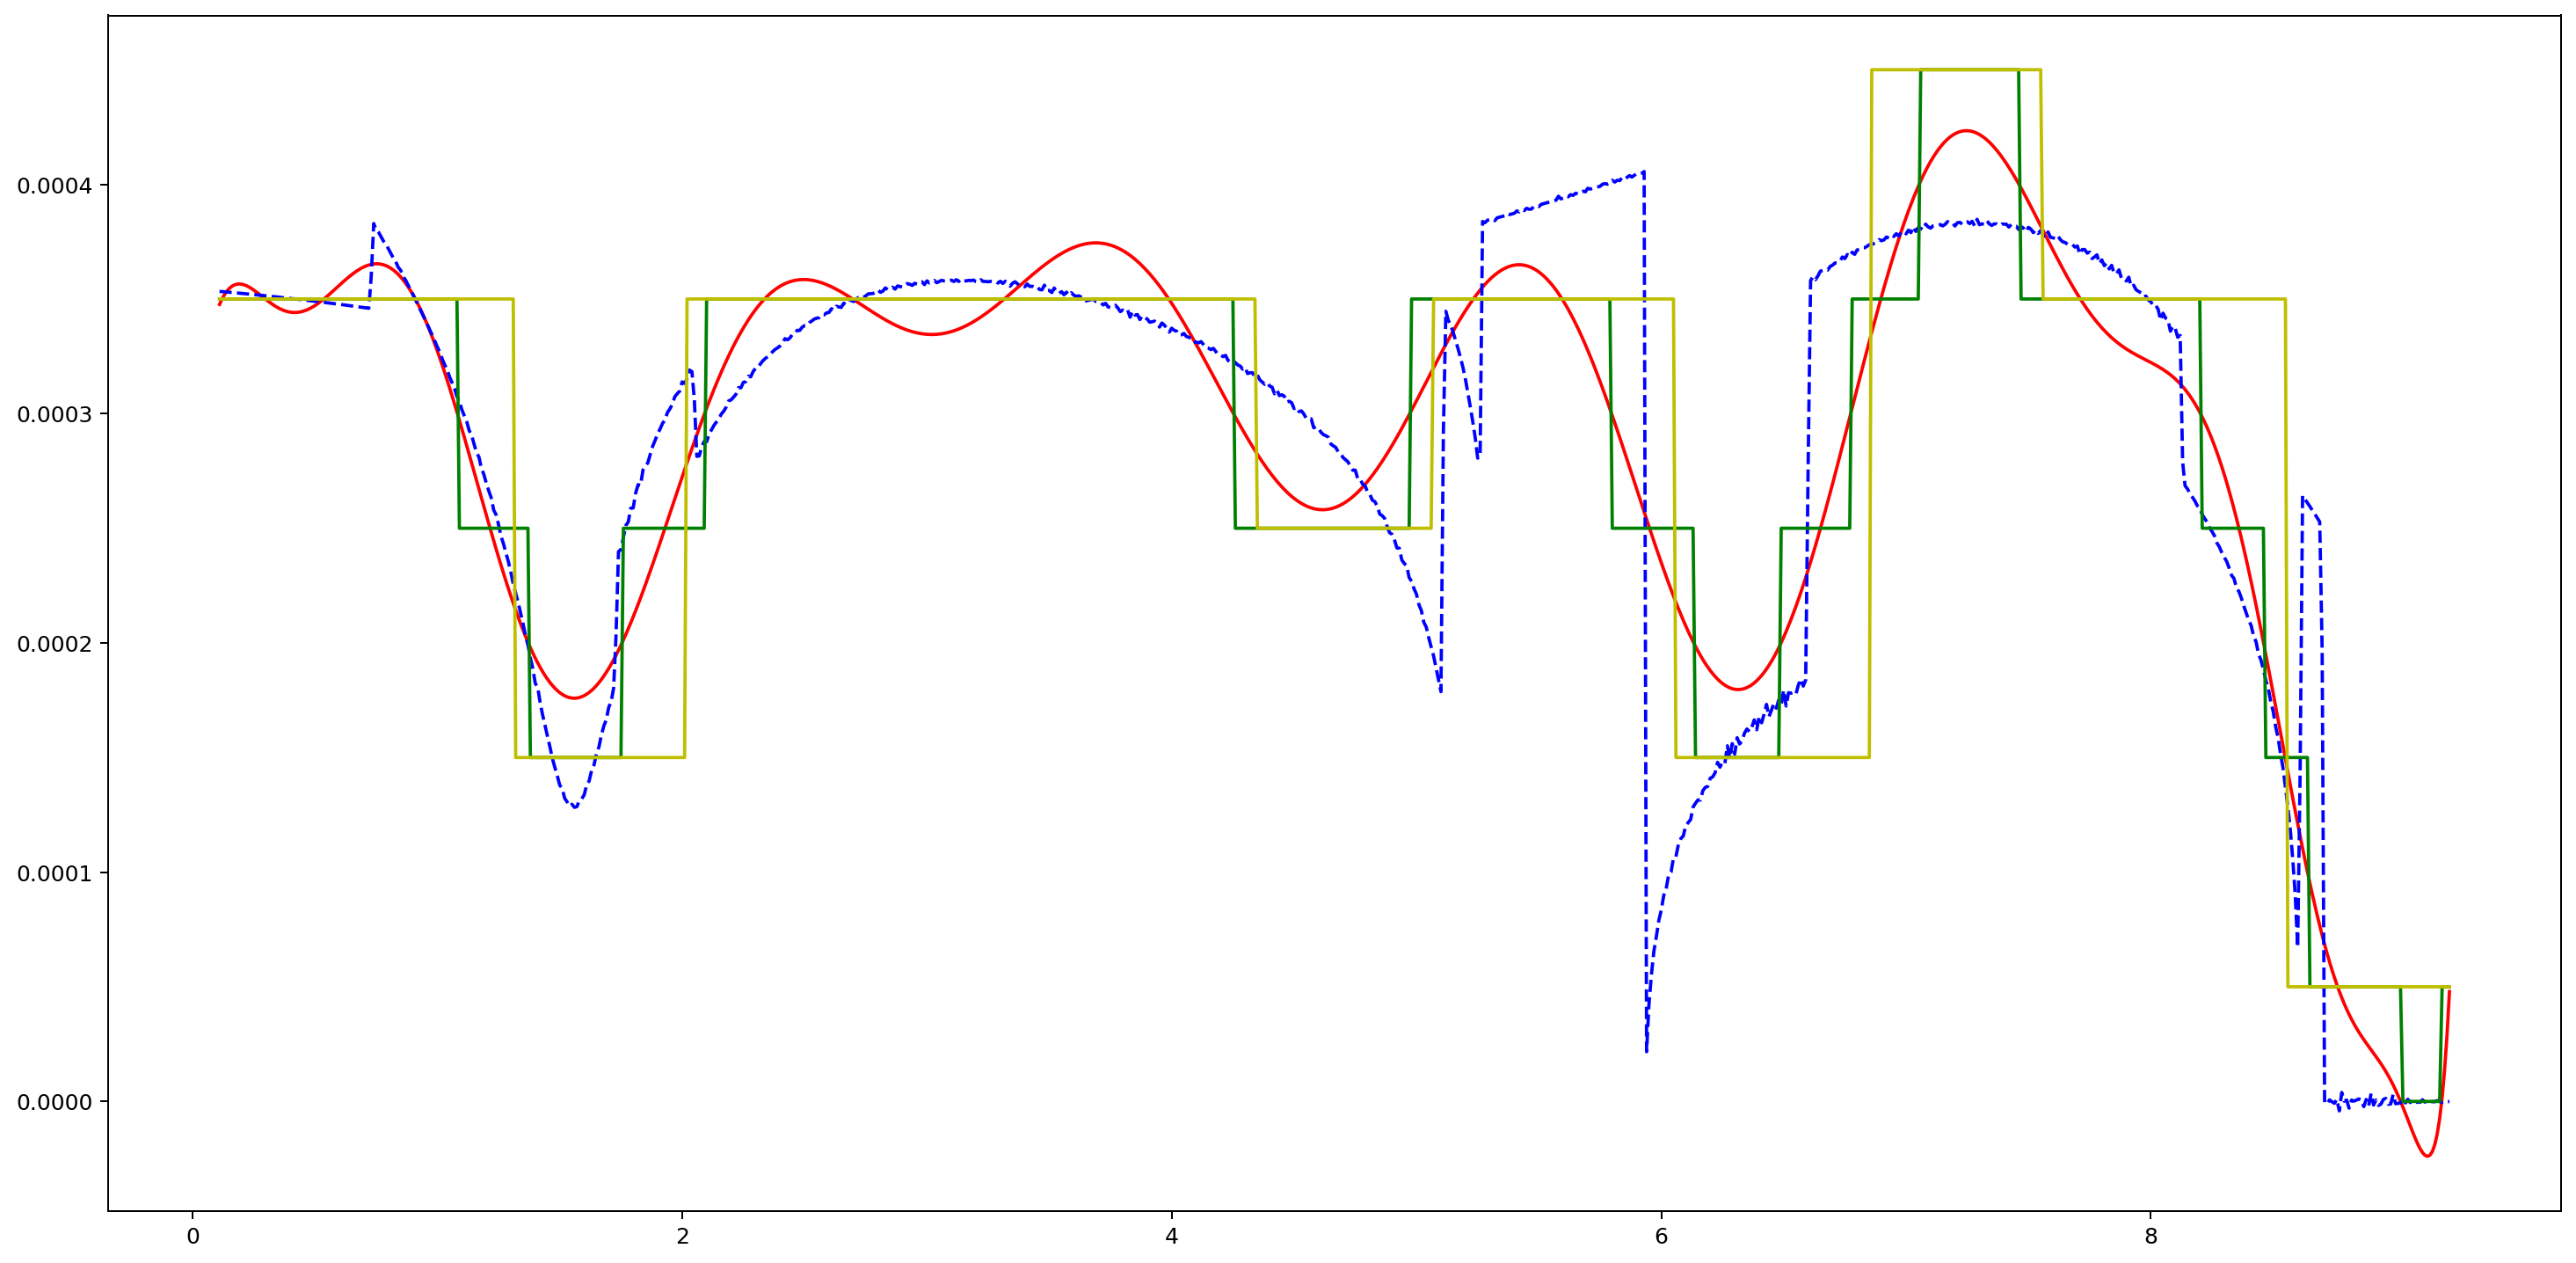

In [11]:
#yellow plot is the new step function
figure(figsize=(20, 10), dpi=180)
plt.plot(x, model_plot(x),'r')
plt.plot(x, y, 'b--')
plt.plot(x, z, 'g')
plt.plot(x, growth_adjust, 'y')

In [12]:
df["adjust"]=growth_adjust
df

Density   Growth_Rate  Growth_approx   adjust
0       0.11  3.533045e-04        0.00035  0.00035
1       0.12  3.532331e-04        0.00035  0.00035
2       0.13  3.531378e-04        0.00035  0.00035
3       0.14  3.530416e-04        0.00035  0.00035
4       0.15  3.529463e-04        0.00035  0.00035
..       ...           ...            ...      ...
907     9.18 -1.035845e-07        0.00000  0.00005
908     9.19 -3.654173e-07        0.00005  0.00005
909     9.20  1.600610e-07        0.00005  0.00005
910     9.21 -5.818369e-08        0.00005  0.00005
911     9.22 -5.303511e-08        0.00005  0.00005

[912 rows x 4 columns]

In [13]:
turn1 = [0]
# if two successive datapoints have different growth rate, mark it as turning points
for i in range(len(x)-1):
    if growth_adjust[i]!=growth_adjust[i+1]:
        turn1.append(x[i])
turn1.append(x[len(x)-1])
turn1

[0, 1.31, 2.01, 4.34, 5.06, 6.05, 6.85, 7.55, 8.55, 9.22]

In [14]:
# between each turning point, the growth rate is constant, by using density/rate we could get time.
time = [0]
t= 0
for i in range(len(turn1)-1):
    index = int((turn1[i+1]+turn1[i])/2*100)
    rate = df["adjust"][index]
    t = t+int((turn1[i+1]-turn1[i])/rate)
    time.append(t)
time
# these are the time required to reach each turning points

[0, 3742, 8408, 15065, 17944, 20772, 26105, 27660, 30517, 43916]

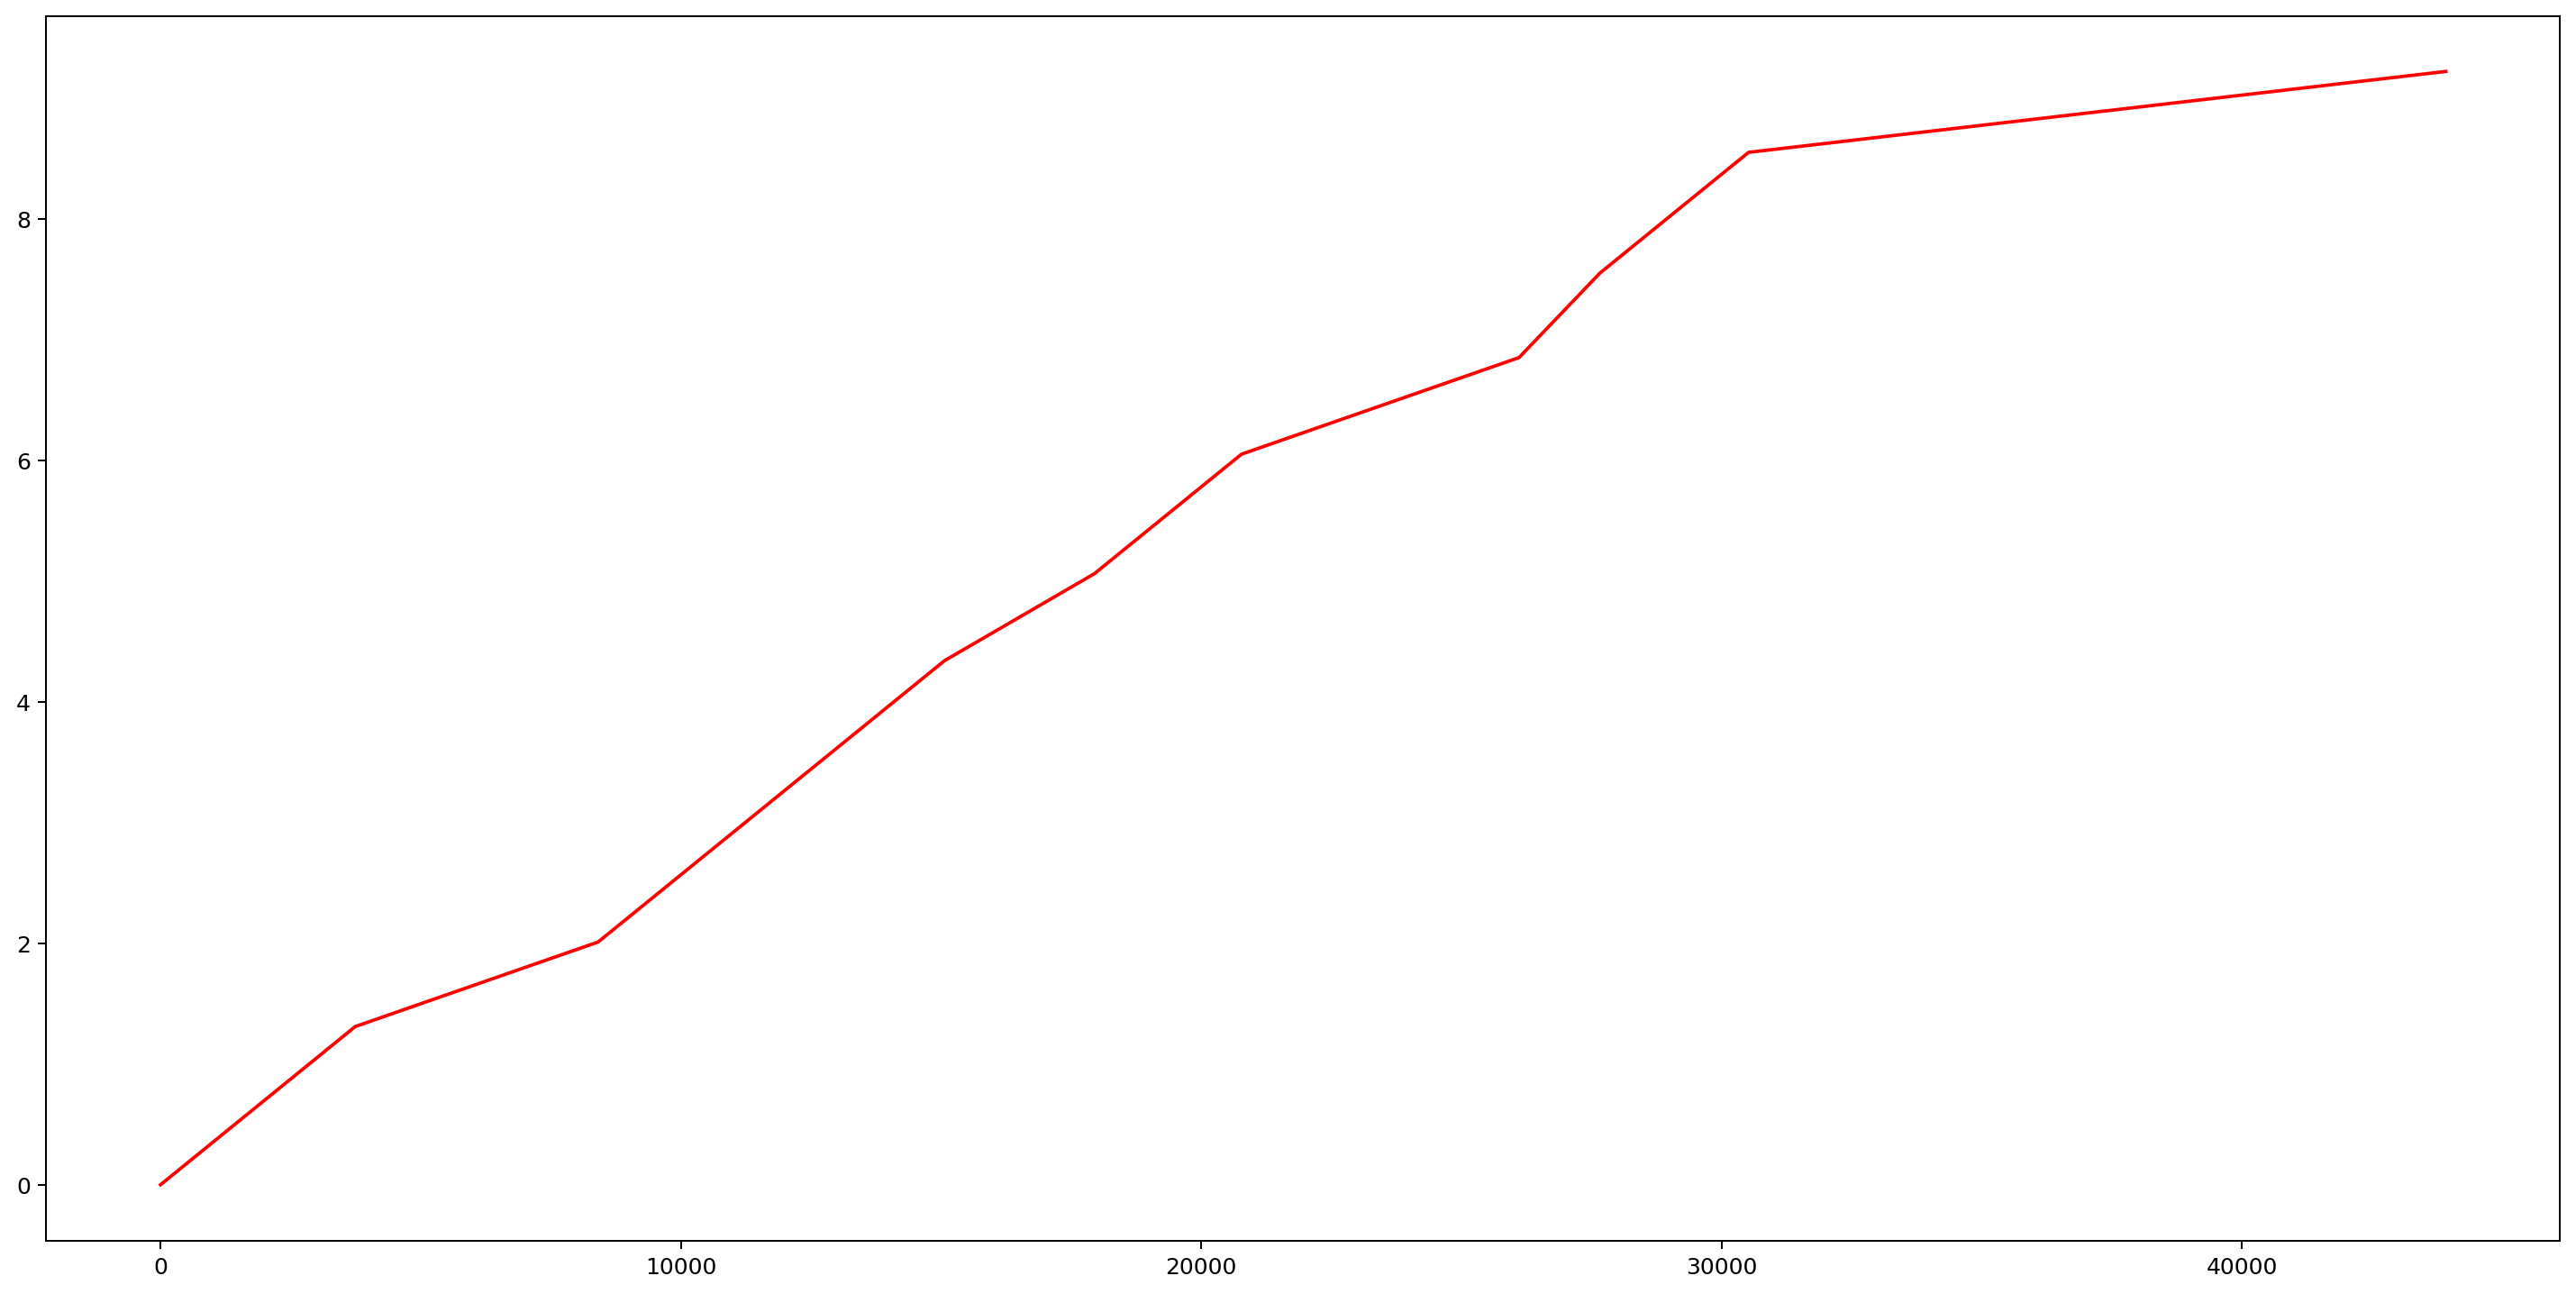

In [15]:
figure(figsize=(20, 10), dpi=180)
plt.plot(time, turn1,'r')
# density vs time plot

In [16]:
def lin_equ(i,x1,y1,x2,y2):
    m = float((y2-y1) / (x2-x1))
    c = y2-m*x2
    print("equation ",i,": m = ",m,", c = ",c)

In [17]:
# this is density versus time
for i in range(len(turn1)-1):
    lin_equ(i,time[i],turn1[i],time[i+1],turn1[i+1])
print("-----------------------------------------")
# this is time versus density
for i in range(len(turn1)-1):
    lin_equ(i,turn1[i],time[i],turn1[i+1],time[i+1])

equation  0 : m =  0.00035008017103153394 , c =  0.0
equation  1 : m =  0.00015002143163309037 , c =  0.7486198028289759
equation  2 : m =  0.00035000751089079164 , c =  -0.9328631515697765
equation  3 : m =  0.00025008683570684254 , c =  0.572441820076417
equation  4 : m =  0.00035007072135785015 , c =  -1.221669024045264
equation  5 : m =  0.0001500093755859741 , c =  2.9340052503281457
equation  6 : m =  0.00045016077170418017 , c =  -4.901446945337624
equation  7 : m =  0.00035001750087504407 , c =  -2.131484074203719
equation  8 : m =  5.0003731621762816e-05 , c =  7.024036122098664
-----------------------------------------
equation  0 : m =  2856.4885496183206 , c =  0.0
equation  1 : m =  6665.714285714288 , c =  -4990.085714285717
equation  2 : m =  2857.0815450643777 , c =  2665.266094420602
equation  3 : m =  3998.6111111111127 , c =  -2288.97222222223
equation  4 : m =  2856.565656565656 , c =  3489.777777777781
equation  5 : m =  6666.250000000002 , c =  -19558.812500000007

In [54]:
# given density, return how long will it take to grow from 0g/L to given density
def t_v_d(d):
    t = np.piecewise(float(d), [((d >= 0) & (d < 1.31)),((d >= 1.31) & (d < 2.01)),
                        ((d >= 2.01) & (d < 4.34)),((d >= 4.34) & (d < 5.06)),
                        ((d >= 5.06) & (d < 6.05)),((d >= 6.05) & (d < 6.85)),
                        ((d >= 6.85) & (d < 7.55)),((d >= 7.55) & (d < 8.55)),
                        ((d >= 8.55))], 
                     [lambda d :2856.4885496183206*d,
                      lambda d : 6665.714285714288*d-4990.085714285717,
                      lambda d : 2857.0815450643777*d+2665.266094420602,
                      lambda d : 3998.6111111111127*d-2288.97222222223,
                      lambda d : 2856.565656565656*d+3489.777777777781,
                      lambda d : 6666.250000000002*d-19558.812500000007,
                      lambda d : 2221.4285714285706*d+10888.214285714294,
                      lambda d : 2856.9999999999973*d+6089.65000000002,
                      lambda d : 19998.507462686568*d-140470.23880597018]
                      )
    return t

In [55]:
# given time, return density will it reached from 0g/L
def d_v_t(t):
    d = np.piecewise(float(t), [((t >= 0) & (t < 3742)),((t >= 3742) & (t < 8408)),
                        ((t >= 8408) & (t < 15065)),((t >= 15065) & (t < 17944)),
                        ((t >= 17944) & (t < 20772)),((t >= 20772) & (t < 26105)),
                        ((t >= 26105) & (t < 27660)),((t >= 27660) & (t < 30517)),
                        ((t >= 30517))], 
                     [lambda t : 0.00035008017103153394*t,
                      lambda t : 0.00015002143163309037*t+0.7486198028289759,
                      lambda t : 0.00035000751089079164*t-0.9328631515697765,
                      lambda t : 0.00025008683570684254*t+0.572441820076417,
                      lambda t : 0.00035007072135785015*t-1.221669024045264,
                      lambda t : 0.0001500093755859741*t+2.9340052503281457,
                      lambda t : 0.00045016077170418017*t-4.901446945337624,
                      lambda t : 0.00035001750087504407*t-2.131484074203719,
                      lambda t : (5.0003731621762816e-05)*t+7.024036122098664]
                      )
    return d

In [56]:
d_v_t(33444)

array(8.69636092)

In [57]:
# given current density and a time, return the future density level it will reached
# used to check whether the solution will work, exists as a condition.
def growth_process(curr_p,t):
    curr_t = t_v_d(curr_p)
    fut_t = t+curr_t
    fut_p = d_v_t(fut_t)
    return fut_p

In [36]:
density = []
time = []
volume = []
mass = []

'density_time_combination_3.csv'

time set for t = 1.5 min

In [63]:
# this function set time t as fixed, and return all the possible solution with density in range (0,10)
# volume in range (0,10000) in ml.
def set_t_heatmap(t):
    density = []
    time = []
    volume = []
    mass = []
    for p in range(100):
                for v in range(1,10000):
                        p1 = ((10000-v)/1000)*(p/10)/10   # new density
                        if p1>=0.5:
                            if abs(p/10 - growth_process(p1,t))<=0.01:
                                density.append(p/10)
                                volume.append(v)
                                time.append(t)
                                output = p/10*v/1000*365*1440/t
                                mass.append(output)

    df_final = pd.DataFrame(columns=['density','time', 'volume','mass'])
    df_final["density"] = density
    df_final["time"] = t
    df_final["volume"] = volume
    df_final["mass"] = mass
    name = "density_time_combination_"+str(t)+".csv"
    df_final.to_csv(name)

In [72]:
set_t_heatmap(1)

In [64]:
set_t_heatmap(3)
print("-----------------------")
set_t_heatmap(6)
print("-----------------------")
set_t_heatmap(9)

-----------------------
-----------------------


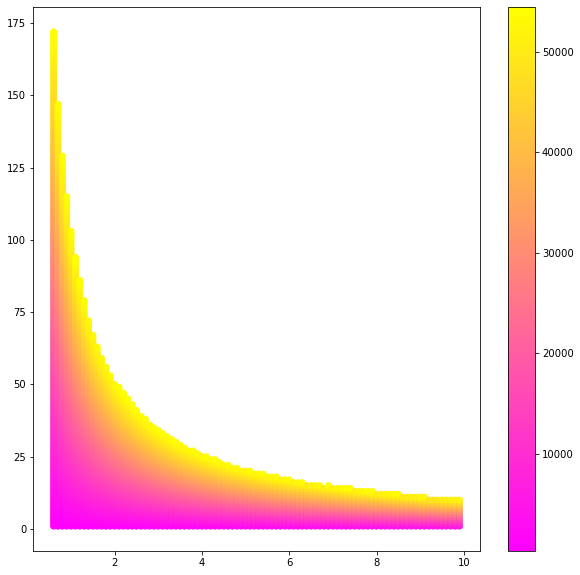

In [73]:
df_1 = pd.read_csv("density_time_combination_1.csv")
fig = plt.figure(figsize = (10, 10))

plt.scatter(df_1["density"], df_1["volume"], c=df_1["mass"], cmap = color_map)
plt.colorbar()
# To show the plot
plt.show()

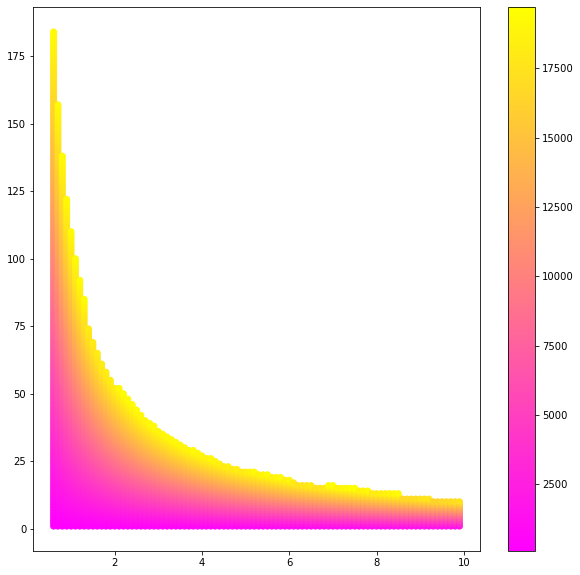

In [69]:
color_map = plt.get_cmap('spring')

df_3 = pd.read_csv("density_time_combination_3.csv")
fig = plt.figure(figsize = (10, 10))

plt.scatter(df_3["density"], df_3["volume"], c=df_3["mass"], cmap = color_map)
plt.colorbar()
# To show the plot
plt.show()

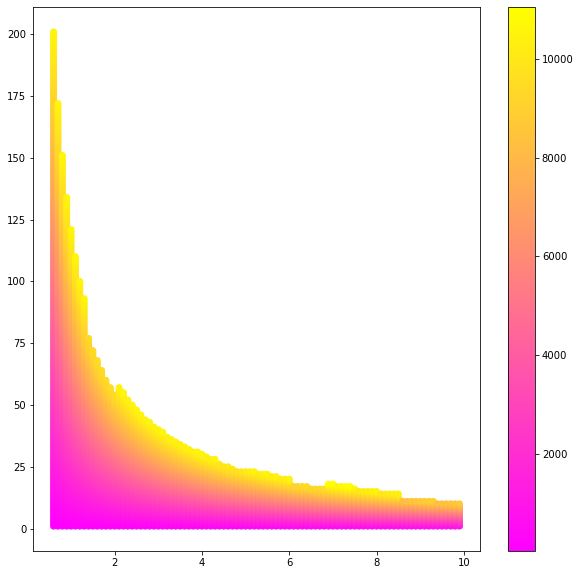

In [70]:
df_6 = pd.read_csv("density_time_combination_6.csv")
fig = plt.figure(figsize = (10, 10))

plt.scatter(df_6["density"], df_6["volume"], c=df_6["mass"], cmap = color_map)
plt.colorbar()
# To show the plot
plt.show()

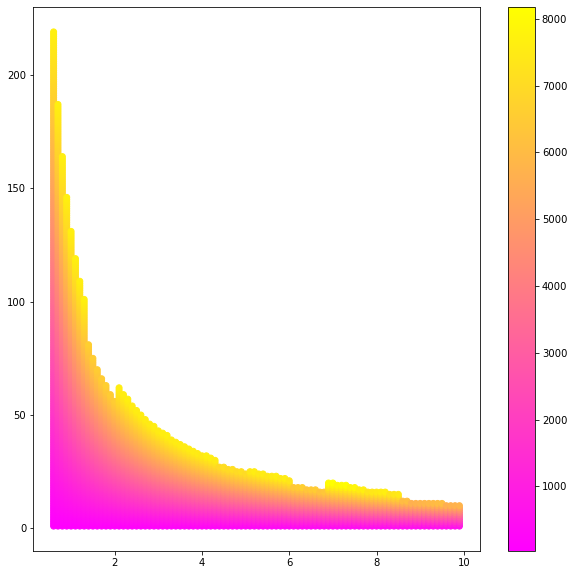

In [71]:
df_9 = pd.read_csv("density_time_combination_9.csv")
fig = plt.figure(figsize = (10, 10))

plt.scatter(df_9["density"], df_9["volume"], c=df_9["mass"], cmap = color_map)
plt.colorbar()
# To show the plot
plt.show()

# please be aware the following triple loop will take 11 hours to run

In [ ]:
# use triple for loop to generate
import datetime

def heatmap_gen(density,time,volume,mass):
    for p in range(100):
        print("Current Progress: ",p,"%")
        print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
        for t in range(1,3*1440):
            for v in range(1,10000,5):
                p1 = ((10000-v)/1000)*(p/10)/10   # new density
                if p1>=0.01:
                    if abs(p/10 - growth_process(p1,t))<=0.01:
                        density.append(p/10)
                        time.append(t)
                        volume.append(v)
                        output = p/10*v/1000*365*1440/t
                        mass.append(output)

In [132]:
heatmap_gen(density,time,volume,mass)

Current Progress:  0 %
Timestamp: 2022-07-11 04:56:26
Current Progress:  1 %
Timestamp: 2022-07-11 04:56:28
Current Progress:  2 %
Timestamp: 2022-07-11 05:03:29
Current Progress:  3 %
Timestamp: 2022-07-11 05:10:54
Current Progress:  4 %
Timestamp: 2022-07-11 05:18:27
Current Progress:  5 %
Timestamp: 2022-07-11 05:26:23
Current Progress:  6 %
Timestamp: 2022-07-11 05:34:19
Current Progress:  7 %
Timestamp: 2022-07-11 05:42:17
Current Progress:  8 %
Timestamp: 2022-07-11 05:50:18
Current Progress:  9 %
Timestamp: 2022-07-11 05:58:22
Current Progress:  10 %
Timestamp: 2022-07-11 06:06:09
Current Progress:  11 %
Timestamp: 2022-07-11 06:13:43
Current Progress:  12 %
Timestamp: 2022-07-11 06:21:15
Current Progress:  13 %
Timestamp: 2022-07-11 06:28:47
Current Progress:  14 %
Timestamp: 2022-07-11 06:36:21
Current Progress:  15 %
Timestamp: 2022-07-11 06:43:56
Current Progress:  16 %
Timestamp: 2022-07-11 06:51:31
Current Progress:  17 %
Timestamp: 2022-07-11 06:59:07
Current Progress:  1

In [133]:
df_final = pd.DataFrame(columns=['density', 'time', 'volume','mass'])
df_final["density"] = density
df_final["time"] = time
df_final["volume"] = volume
df_final["mass"] = mass
df_final.head(5)

density  time  volume     mass
0        1     1       1    52.56
1        1     1       6   315.36
2        1     1      11   578.16
3        1     1      16   840.96
4        1     1      21  1103.76

In [134]:
df_final.to_csv("density_time_combination.csv")

focus on model 1 first
for optimization： need to consider:
- interval of harvesting t (in min)
- volume amount harvesting v (volume in ml)
- level of density when harvesting p
Assume maximize the harvest amount by 1 year.

number of harvesting N = 365*1440/t

mass obtained m = p*v

new level of density p1 = (10-v)p/10

objective function: M = N*(p*v)

constraints: growth rate at p1* t * (growth_rate) = p

cost per harvest and total expected budget?

therefore, need a growth rate function in terms of density 
target variable：time t, volume v, density p

# generate heatmap with the dataset

In [135]:
df = pd.read_csv("density_time_combination.csv")
df.head(5)

Unnamed: 0  density  time  volume     mass
0           0        1     1       1    52.56
1           1        1     1       6   315.36
2           2        1     1      11   578.16
3           3        1     1      16   840.96
4           4        1     1      21  1103.76

In [136]:
len(df["density"])

5049717

In [137]:
df["density"] = (df["density"]/10).round(2)
df.head(10)

Unnamed: 0  density  time  volume     mass
0           0      0.1     1       1    52.56
1           1      0.1     1       6   315.36
2           2      0.1     1      11   578.16
3           3      0.1     1      16   840.96
4           4      0.1     1      21  1103.76
5           5      0.1     1      26  1366.56
6           6      0.1     1      31  1629.36
7           7      0.1     1      36  1892.16
8           8      0.1     1      41  2154.96
9           9      0.1     1      46  2417.76

In [142]:
max_mass = max(df["mass"])
print(max_mass)
df.loc[df["mass"]==max_mass]
max(df.loc[df["density"]==7.20]["mass"])

54241.92


Unnamed: 0  density  time  volume      mass
99945         99945      0.2     1     516  54241.92
1213174     1213174      1.2     1      86  54241.92

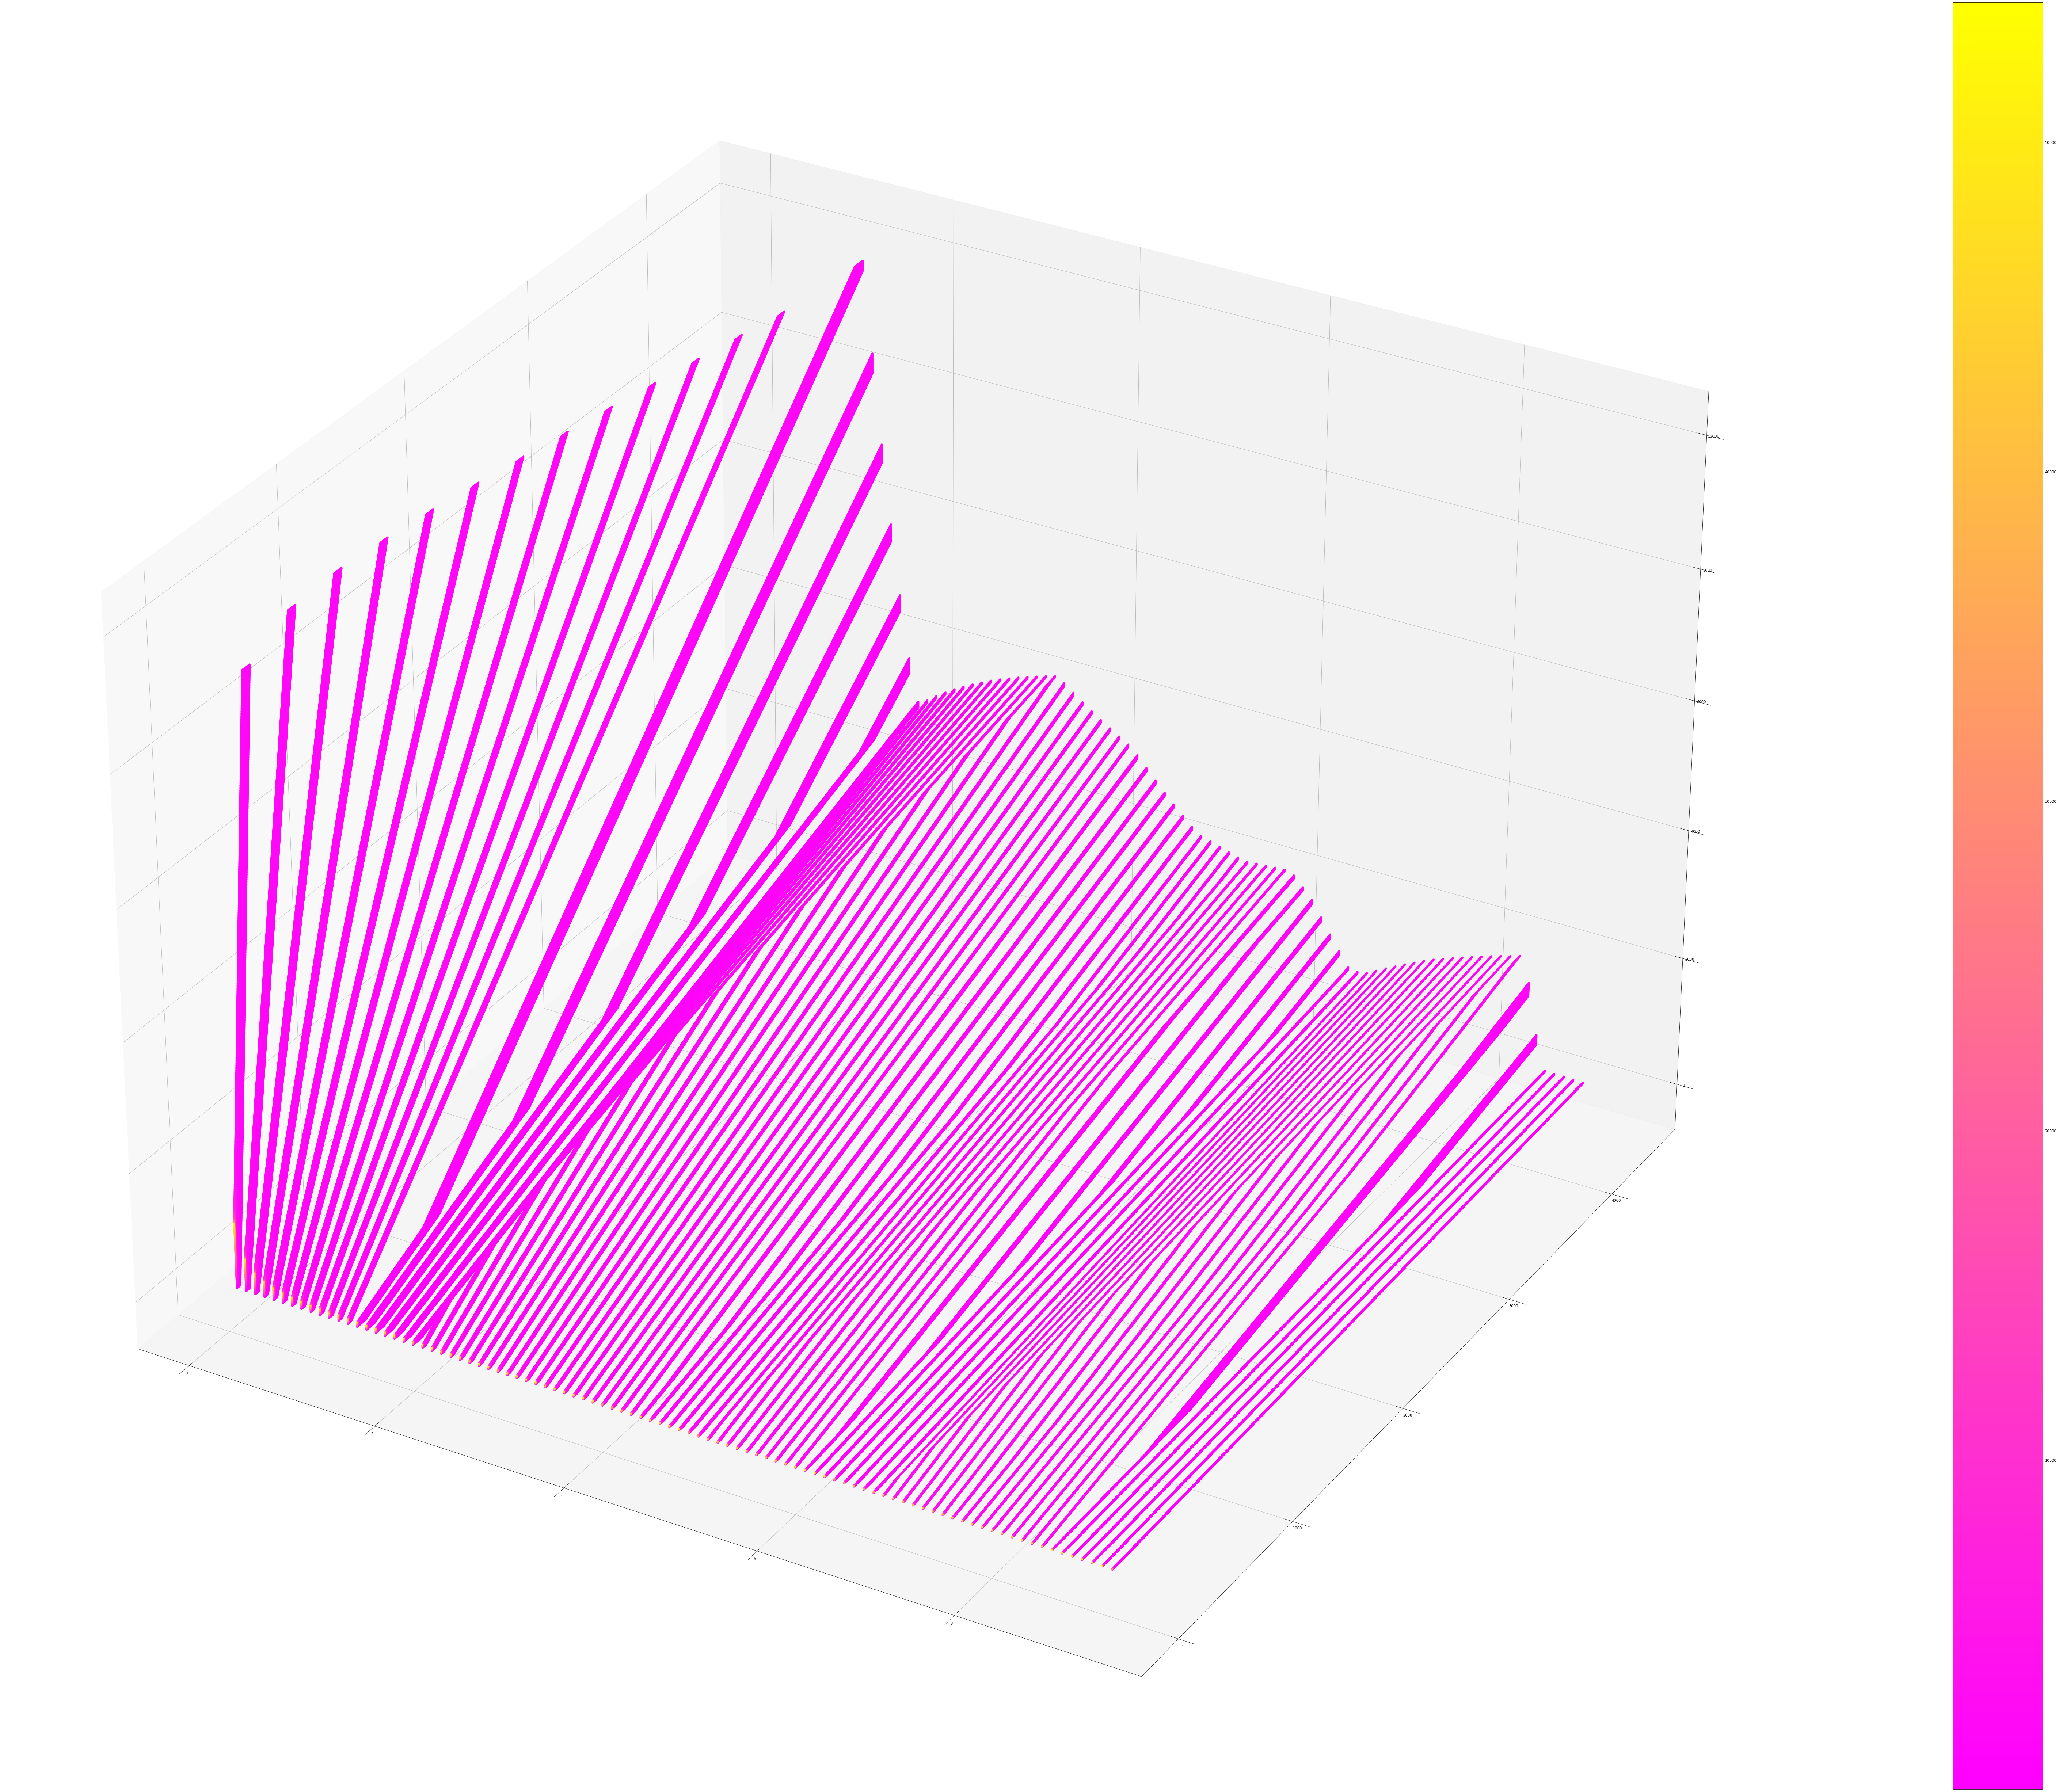

In [144]:
# Import libraries

from mpl_toolkits import mplot3d
 
# Define Dataset

x = df["density"]
y = df["time"]
z = df["volume"]
m = df["mass"]
 
# Creating figure

fig = plt.figure(figsize = (160, 90))
ax = plt.axes(projection ="3d")
  
# Creat color map

color_map = plt.get_cmap('spring')
 
# Create scatter plot and colorbar

scatter_plot = ax.scatter3D(x, y, z,
                            c=m,
                            cmap = color_map)
 
plt.colorbar(scatter_plot)
 
# Show plot

plt.show()

In [168]:
# sort the mass from high to low and get the corresponding harvesting scheme
df_top = df.sort_values(by='mass', ascending=False)[:100]

In [169]:
df_top = df_top[["density","time","volume","mass"]]
df_top

density  time  volume      mass
99945        0.2     1     516  54241.92
1213174      1.2     1      86  54241.92
206          0.1     1    1031  54189.36
427099       0.5     1     206  54136.80
205          0.1     1    1026  53926.56
...          ...   ...     ...       ...
2783865      2.6     1      36  49196.16
3246532      3.6     1      26  49196.16
187          0.1     1     936  49196.16
538463       0.6     1     156  49196.16
4759276      8.5     1      11  49143.60

[100 rows x 4 columns]

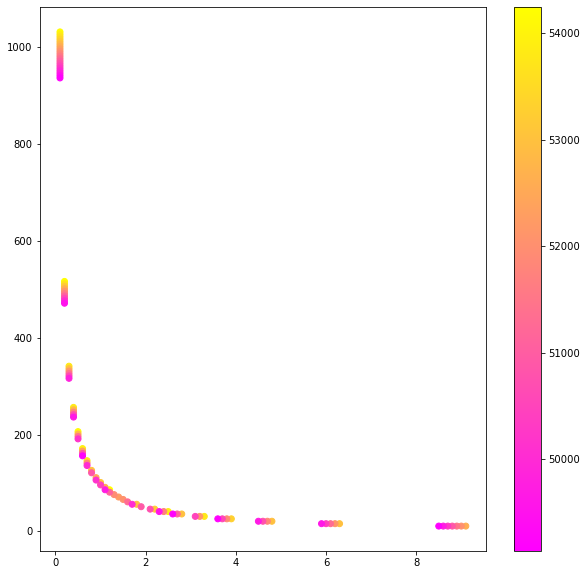

In [170]:
# for the top harvesting schemes, the relationship between density and volume is plotted.
fig = plt.figure(figsize = (10, 10))

plt.scatter(df_top["density"], df_top["volume"], c=df_top["mass"], cmap = color_map)
plt.colorbar()
# To show the plot
plt.show()

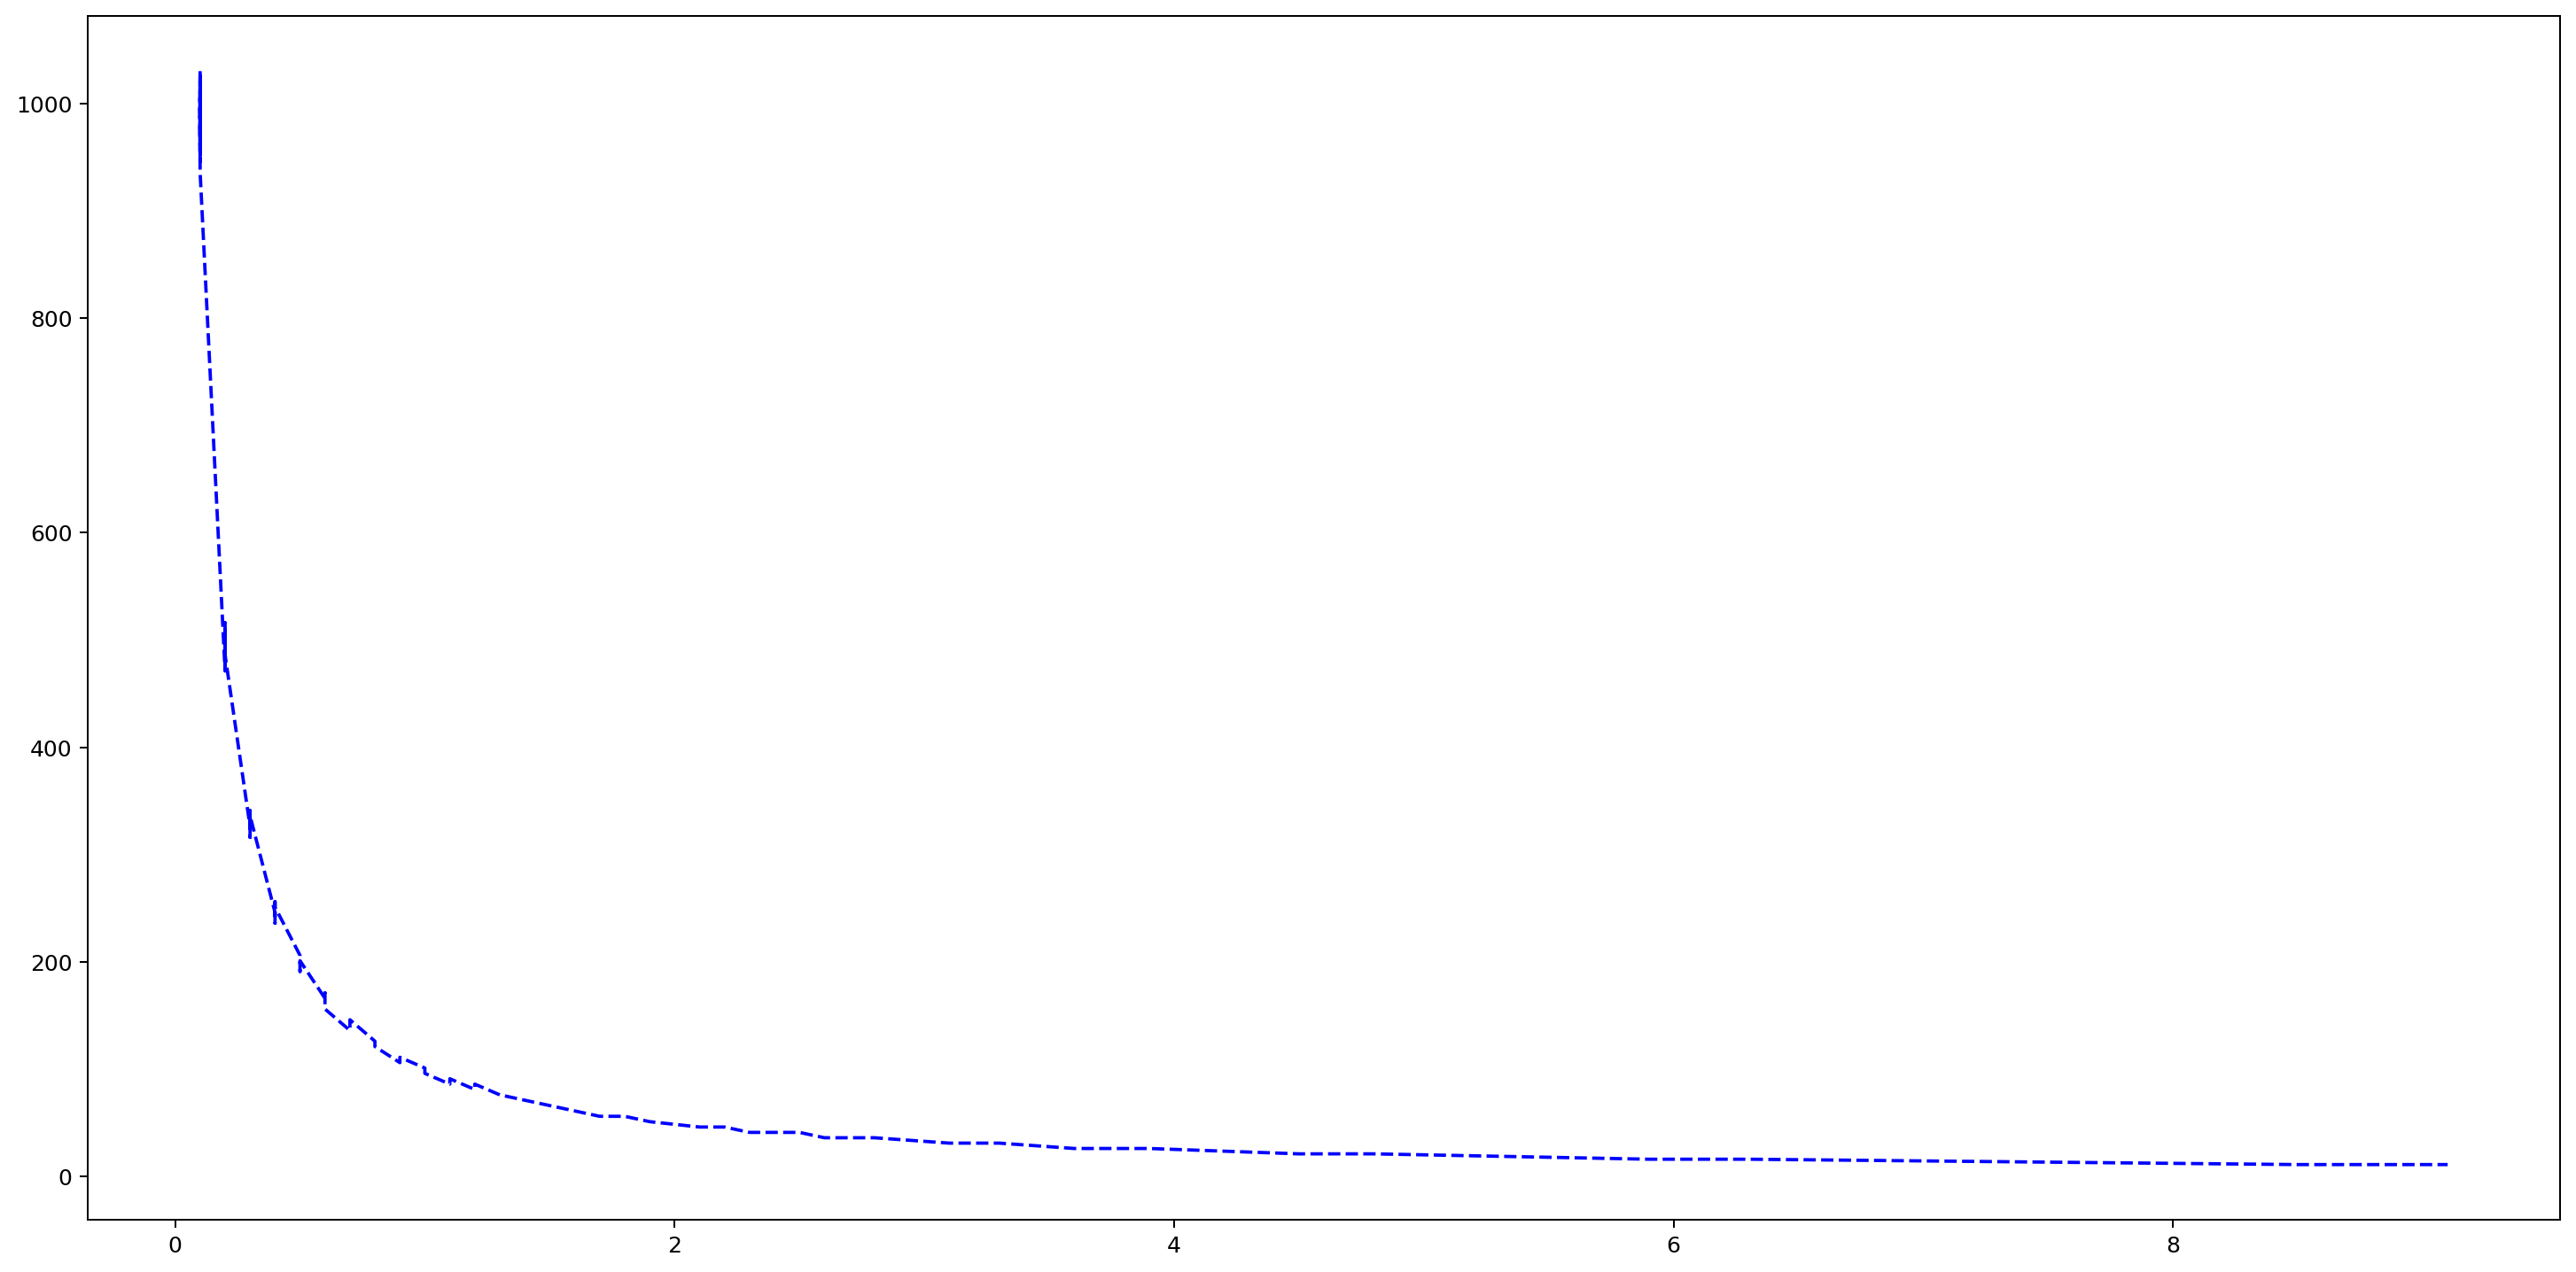

In [179]:
degree = 1
df_top = df_top.sort_values(by='density', ascending=True)
x1 = df_top["density"]
y1 = df_top["volume"]
theta1 = np.polyfit(x1,y1, deg= degree)
model_plot1 = np.poly1d(theta)

figure(figsize=(20, 10), dpi=180)
plt.plot(x1, y1, 'b--')
#plt.plot(x1, model_plot1(x1),'r')

# Gurobi Solution (error)

In [181]:
model = gp.Model('algae harvest')
model.setParam("NonConvex",2)

Academic license - for non-commercial use only - expires 2023-07-07
Using license file C:\Users\timwy\gurobi.lic
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1


Need to create a function to calculate the growth process.
define time interval as 1 min

In [182]:
#Define DVs
t = model.addVar(lb=1,ub=1440*365,vtype = GRB.INTEGER,name = "harvest interval")
v = model.addVar(lb=0,ub=10000,vtype = GRB.INTEGER,name = "harvest volume")
p = model.addVar(lb=0,ub=10,vtype = GRB.CONTINUOUS,name = "harvest density")
N = model.addVar(lb=1/(1440*365),ub=1,vtype = GRB.INTEGER,name = "interval reversal")
mass = model.addVar(vtype = GRB.CONTINUOUS,name = "harvest mass")
p1 = model.addVar(lb=0,ub=10,vtype = GRB.CONTINUOUS,name = "new density")

In [183]:
model.addConstr(mass == p*v)
model.addConstr(p1 == (10000-v)*p/10000)
model.addConstr(N*t == 1)

<gurobi.QConstr Not Yet Added>

In [184]:
model.setObjective(365*1440*mass*N,GRB.MAXIMIZE)

Constraint 1: growth rate should match the time

In [185]:
model.addConstr(p == growth_process(p1,t))

TypeError: float() argument must be a string or a number, not 'Var'